In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras import backend as K
import gc

# RealWaste Dataset


## Loading the Dataset
This cell loads the **RealWaste** dataset, which contains images of waste items categorized into multiple classes such as plastic, paper, metal, glass, and organic materials.  
The TensorFlow utility `image_dataset_from_directory()` automatically reads the images from the specified directory, resizes them to **256×256**, groups them into batches of **32**, and shuffles them for training.  
This prepares the dataset for use in model training and evaluation. 

In [15]:
#load the dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory=r'../RealWaste',
    batch_size=32,
    image_size=(256,256),     #resizing
    shuffle=True,
    seed=123)

Found 4752 files belonging to 9 classes.


In [16]:
#check which classes are in the dataset
dataset.class_names

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

## Training dataset

In [17]:
train_dataset=dataset.take(104) #take first 139 batches as traning
remaining=dataset.skip(104) #take the remaning batches

print(f"Percentage of traning set {round(((len(train_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(remaining)/len(dataset))*100))} %")

Percentage of traning set 70 %
Percentage of test set 30 %


## Test Dataset

In [18]:
test_dataset=remaining.take(22)
cv_dataset=remaining.skip(22)
print(f"Percentage of traning set {round(((len(test_dataset)/len(dataset))*100))} %")
print(f"Percentage of test set {round(((len(cv_dataset)/len(dataset))*100))} %")

Percentage of traning set 15 %
Percentage of test set 15 %


## Save the splits

In [19]:
test_dataset.save('saved_datasets/test_dataset')
train_dataset.save('saved_datasets/train_dataset')
cv_dataset.save('saved_datasets/cv_dataset')

## Load The saved dataset

In [20]:
train_dataset = tf.data.Dataset.load('saved_datasets/train_dataset')
cv_dataset = tf.data.Dataset.load('saved_datasets/cv_dataset')
test_dataset = tf.data.Dataset.load('saved_datasets/test_dataset')

In [21]:
#to use for prediction in the later phase
class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

## to visualize the images

(32, 256, 256, 3)
(32,)


2025-11-26 12:37:05.803946: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


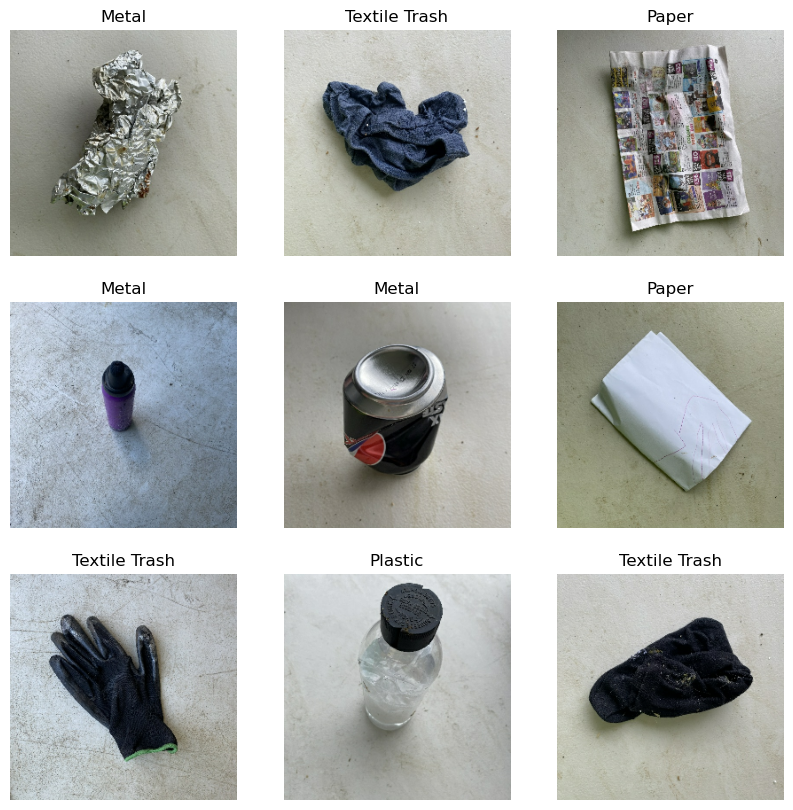

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):

  print(images.shape)
  print(labels.shape)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
len(train_dataset)

104

## A function to count the images class-wise for each split

In [24]:
def class_counts(dataset, num_classes):
    counts = np.zeros(num_classes, dtype=int)
    for _, labels in dataset.unbatch():      
        if len(labels.shape) == 0:           
            counts[labels.numpy()] += 1
        else:                                
            counts[np.argmax(labels.numpy())] += 1
    return counts

In [25]:
train_counts = class_counts(train_dataset, 9)
train_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

2025-11-26 12:37:08.467506: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([325, 293, 313, 528, 342, 361, 647, 224, 295])

In [26]:
test_counts = class_counts(test_dataset, 9)
test_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

array([ 68,  59,  59, 128,  83,  61, 141,  38,  67])

In [27]:
cv_counts = class_counts(cv_dataset, 9)
cv_counts # how many images are there for each class
#class_names = ['Cardboard', 'Food Organics', 'Glass', 'Metal','Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']

2025-11-26 12:37:09.364483: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


array([ 71,  60,  52, 127,  74,  70, 143,  49,  74])

## Data Preprocessing, Augmentation, and Callbacks

- **Rescaling & Resizing:**  
  The `rescale_resize` Sequential model normalizes pixel values to the `[0,1]` range and resizes all images to **128×128** to ensure uniform input dimensions.

- **Data Augmentation:**  
  The `data_augmentation` Sequential model introduces random transformations such as horizontal flips, rotations, zooms, and translations to improve the model’s generalization by simulating real-world variations in waste images.

- **Training Callbacks:**  
  - `ReduceLROnPlateau`: Automatically reduces the learning rate when validation loss stops improving, helping finer convergence.  
  - `EarlyStopping`: Stops training early if validation loss stagnates for several epochs, restoring the best model weights to prevent overfitting.


In [28]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

# CNN Model Architecture (`AdamW(learning_rate=0.001,weight_decay=0.0001)`)

In [29]:
from keras import layers
model = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

/home/himan/Desktop/pattern project/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
from keras.optimizers import Adam,Nadam,AdamW
from keras.losses import SparseCategoricalCrossentropy

optimizer=AdamW(learning_rate=0.001,weight_decay=0.0001)

model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20


I0000 00:00:1764140831.403046    5261 cuda_dnn.cc:529] Loaded cuDNN version 91002


104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.2236 - loss: 2.0872 - val_accuracy: 0.2667 - val_loss: 1.9630 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.3227 - loss: 1.8353 - val_accuracy: 0.3444 - val_loss: 1.7540 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.3789 - loss: 1.6803 - val_accuracy: 0.4208 - val_loss: 1.6678 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4360 - loss: 1.5703 - val_accuracy: 0.4722 - val_loss: 1.4933 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.4612 - loss: 1.4724 - val_accuracy: 0.5194 - val_loss: 1.4199 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.4883 - loss: 1.3918 - val_accuracy: 0.5236 - val_loss: 1.3215 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.5066 - loss: 1.3441 - val

In [32]:
scores=model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6506 - loss: 0.9641


## Plot the results of traning the model

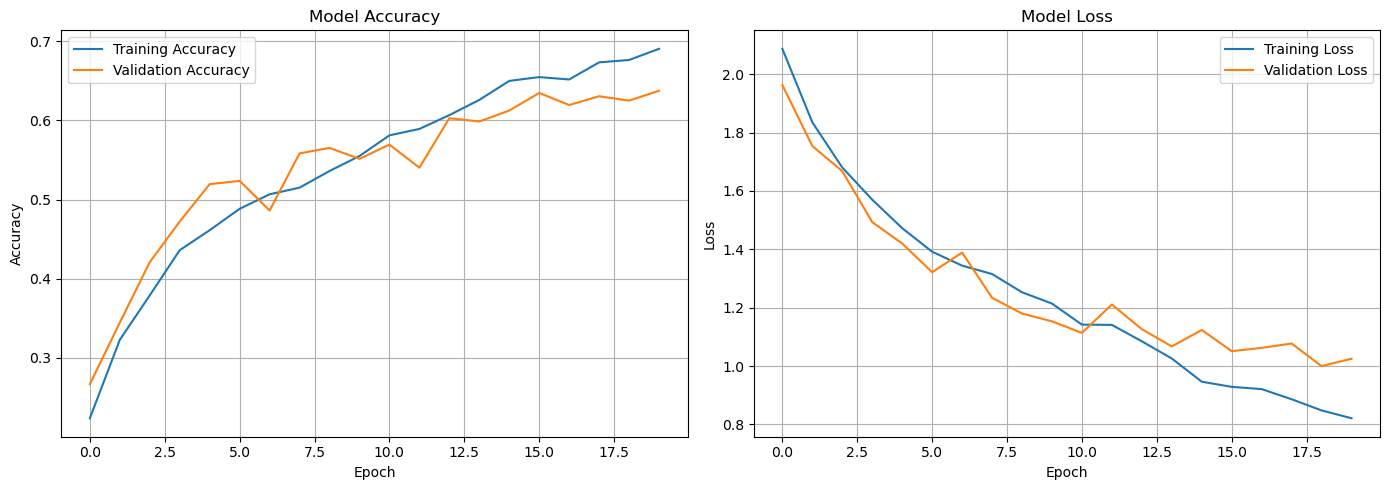


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.6905
Final Validation Accuracy: 0.6375
Final Training Loss: 0.8211
Final Validation Loss: 1.0251
--------------------------------------------------


In [33]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

## Confusion Matrix Generation
This cell compares the model’s predicted classes with the actual labels from a sample batch of the `test_dataset`using **confusion matrix**.  

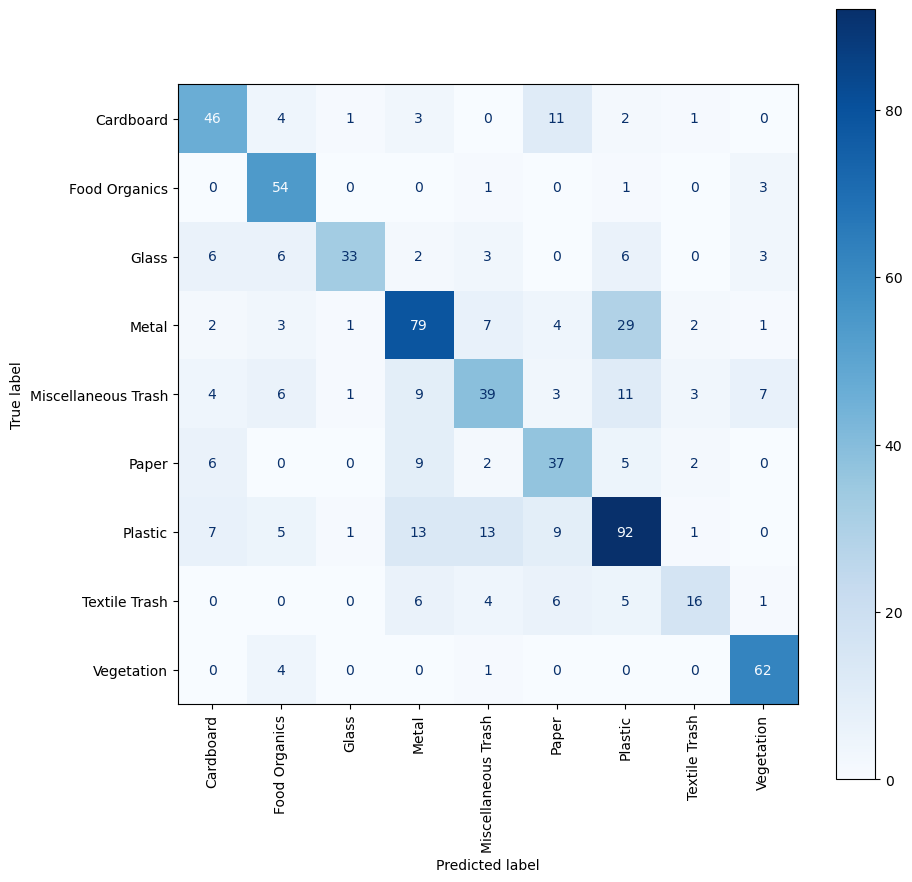

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


### Performance Metrics Calculation
This cell computes key **classification performance metrics** for the model on the RealWaste dataset:

- **Precision:** Measures how many of the predicted positive samples are actually correct.  
- **Recall:** Measures how many of the actual positive samples were correctly identified.  
- **F1 Score:** Harmonic mean of precision and recall, providing a balanced metric between the two.  


In [35]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.6559132345486341
Recall = 0.6505681818181818
F1 Score = 0.6457374356709369


# CNN Model Architecture (`SGD(learning_rate=0.001)`)

In [36]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

In [37]:
from keras import layers
model2 = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

/home/himan/Desktop/pattern project/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
from keras.optimizers import SGD

model2.compile(optimizer=SGD(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [39]:
history = model2.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.1653 - loss: 2.1822 - val_accuracy: 0.1986 - val_loss: 2.1639 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.1953 - loss: 2.1640 - val_accuracy: 0.1986 - val_loss: 2.1445 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.1956 - loss: 2.1522 - val_accuracy: 0.1986 - val_loss: 2.1369 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1947 - loss: 2.1470 - val_accuracy: 0.1986 - val_loss: 2.1348 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1947 - loss: 2.1464 - val_accuracy: 0.1986 - val_loss: 2.1338 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1935 - loss: 2.1449 - val_accuracy: 0.1986 - val_loss: 2.1326 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.1953 - loss: 2.

In [40]:
scores=model2.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2003 - loss: 2.0804


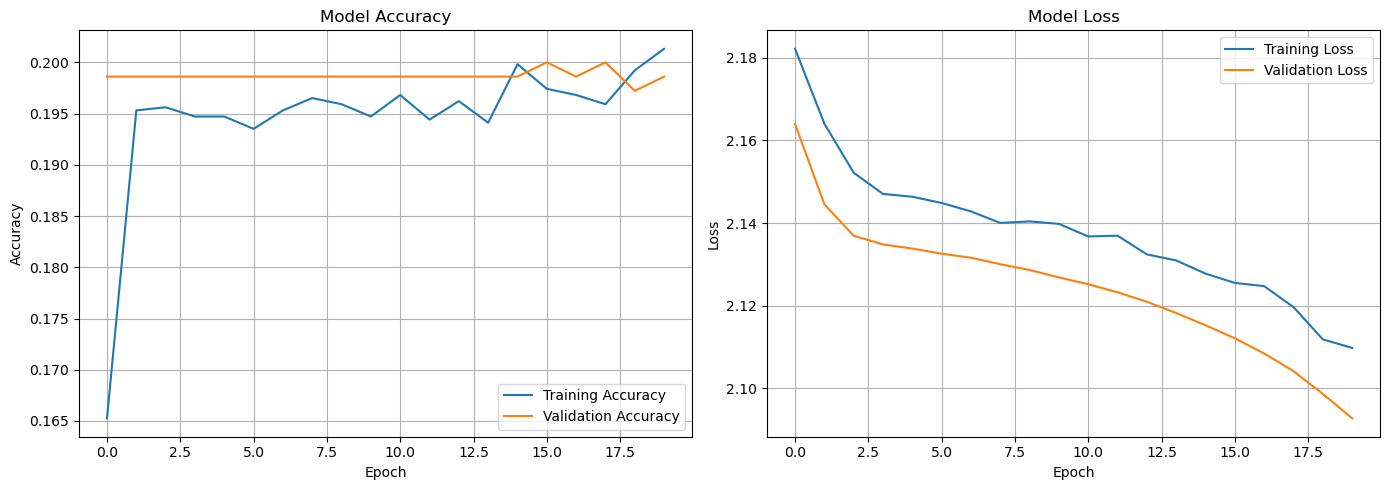


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.2013
Final Validation Accuracy: 0.1986
Final Training Loss: 2.1098
Final Validation Loss: 2.0928
--------------------------------------------------


In [41]:
# Plot Results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

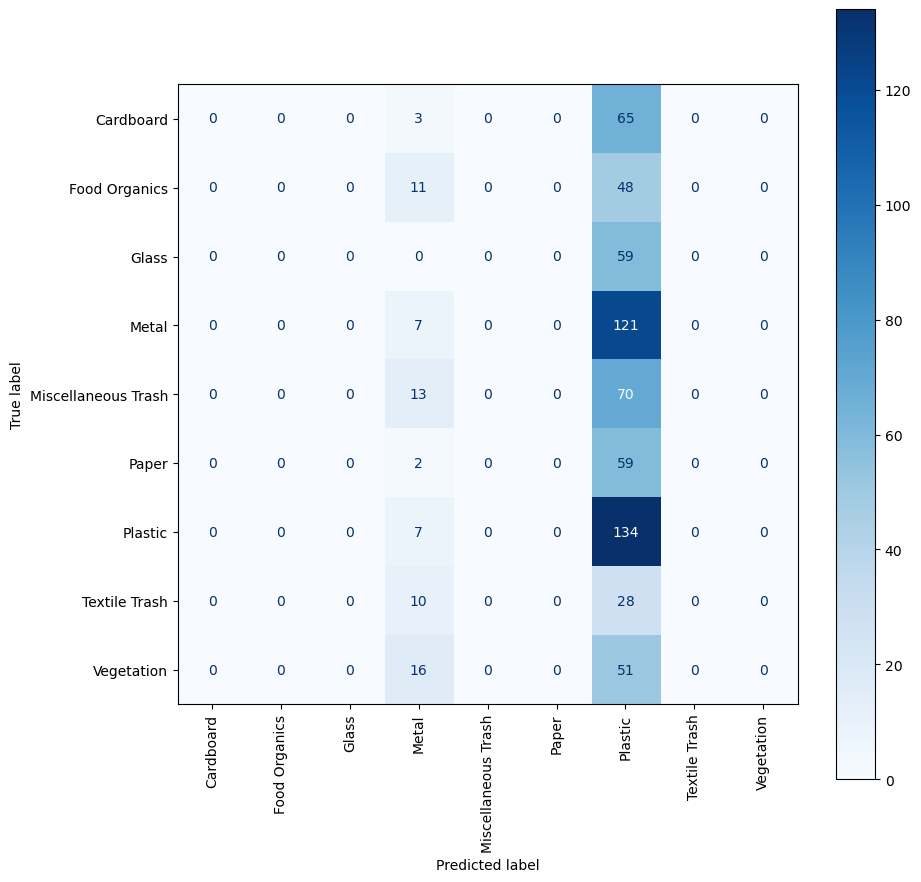

In [42]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model2.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [43]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model2.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.06070999709522475
Recall = 0.2002840909090909
F1 Score = 0.08209136788234006


2025-11-26 12:41:09.572065: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# CNN Model Architecture (`SGD(learning_rate=0.001,momentum=0.9)`)

In [44]:
from keras import Sequential
from keras.layers import Resizing, Rescaling, RandomRotation, RandomFlip , Dropout , RandomZoom , RandomTranslation , BatchNormalization
from keras.callbacks import ReduceLROnPlateau ,EarlyStopping

rescale_resize=Sequential([
    Rescaling(1.0/255),
    Resizing(128,128)
])

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.10),      
    RandomZoom(0.10),         
    RandomTranslation(0.10, 0.10), 
])

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=0.00001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5, 
    restore_best_weights=True
)

In [45]:
from keras import layers
model3 = Sequential([
    rescale_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)),

    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    Dropout(0.4),
    
    layers.Dense(256, activation='relu'),
    
    layers.Dense(9, activation='softmax'),
])

/home/himan/Desktop/pattern project/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
from keras.optimizers import SGD
from keras.losses import SparseCategoricalCrossentropy

model3.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [47]:
history = model3.fit(
    train_dataset,
    epochs=20,
    validation_data=cv_dataset,
    callbacks=[reduce_lr, early_stop],
)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.1884 - loss: 2.1560 - val_accuracy: 0.1986 - val_loss: 2.1324 - learning_rate: 0.0010
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.1956 - loss: 2.1390 - val_accuracy: 0.1986 - val_loss: 2.1163 - learning_rate: 0.0010
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.2037 - loss: 2.1140 - val_accuracy: 0.1972 - val_loss: 2.0745 - learning_rate: 0.0010
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2488 - loss: 2.0215 - val_accuracy: 0.3139 - val_loss: 1.9294 - learning_rate: 0.0010
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.2933 - loss: 1.9257 - val_accuracy: 0.3222 - val_loss: 1.9273 - learning_rate: 0.0010
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.3167 - loss: 1.8605 - val_accuracy: 0.3667 - val_loss: 1.8374 - learning_rate: 0.0010
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - accuracy: 0.3528 - loss: 1.

In [48]:
scores=model3.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5554 - loss: 1.3128


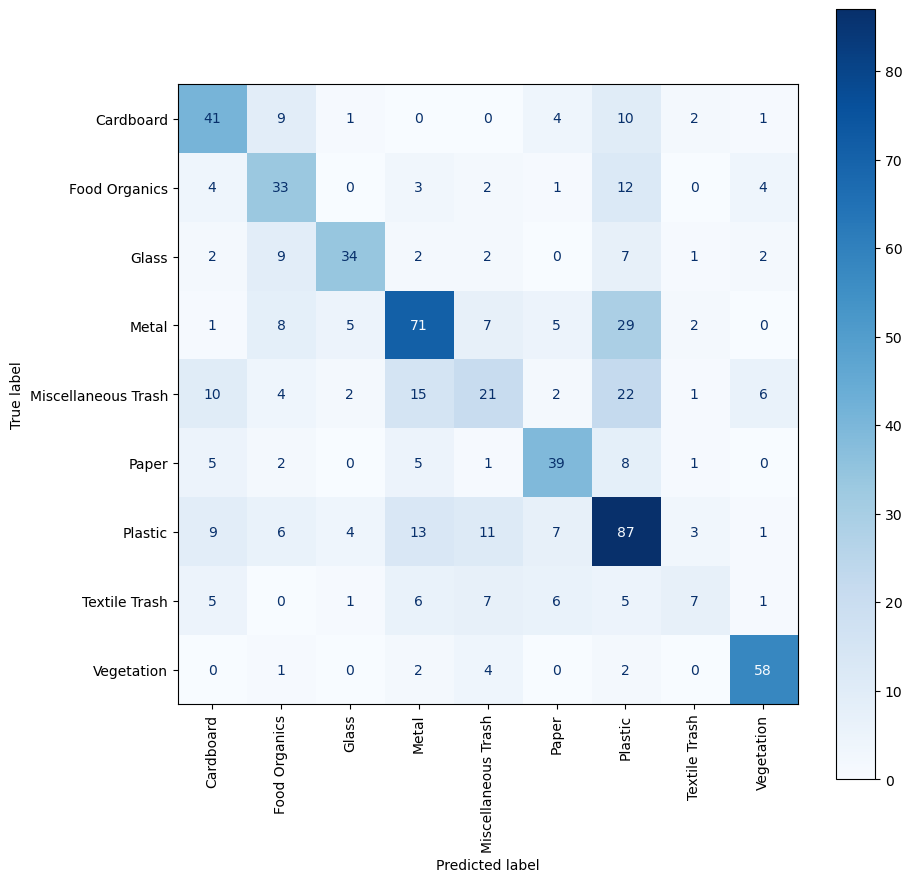

In [49]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model3.predict(imgs, verbose=0)
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [50]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model3.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.5522007700871712
Recall = 0.5553977272727273
F1 Score = 0.5464285708214229


# Inception V3

In [51]:
from keras import applications
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model, Sequential
#from keras.preprocessing.image import ImageDataGenerator

## Loading and Preprocessing the Datasets for InceptionV3
This cell loads the pre-saved **TensorFlow datasets** for training, cross-validation and testing, then defines preprocessing steps specific to the **InceptionV3** architecture.

- The datasets are loaded from disk using `tf.data.Dataset.load()`, restoring previously saved TensorFlow `Dataset` objects.  
- Each image is resized to **524×524** because the **InceptionV3** model expects this.  
- The `preprocess_input()` scales image pixel values to the range **[-1, 1]**, as required by InceptionV3.  
- The preprocessing function returns processed `(image, label)` pairs and prepares the dataset for efficient GPU training.  


In [52]:
from keras.applications.inception_v3 import preprocess_input
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE
TARGET_SIZE = (524, 524)   

# Load the saved datasets
train_dataset = tf.data.Dataset.load("saved_datasets/train_dataset")
cv_dataset    = tf.data.Dataset.load("saved_datasets/cv_dataset")
test_dataset  = tf.data.Dataset.load("saved_datasets/test_dataset")

# Define preprocessing for InceptionV3
def preprocess(image, label):
    # Resize to 299x299
    image = tf.image.resize(image, TARGET_SIZE)
    # Apply InceptionV3 preprocessing (scales to [-1,1])
    image = preprocess_input(image)
    return image, label

print(train_dataset.element_spec) 

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [53]:
train_dataset = (train_dataset
                 .map(preprocess, num_parallel_calls=AUTOTUNE)
                 .shuffle(1000)
                 .prefetch(AUTOTUNE))

cv_dataset = (cv_dataset
              .map(preprocess, num_parallel_calls=AUTOTUNE)
              .prefetch(AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocess, num_parallel_calls=AUTOTUNE)
                .prefetch(AUTOTUNE))

print(train_dataset.element_spec) 

(TensorSpec(shape=(None, 524, 524, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


## Model Architecture: Transfer Learning with InceptionV3

### Phase 1: Feature Extraction (Frozen Base Model)

**Base Model Configuration:**
- **Architecture**: InceptionV3 (pre-trained on ImageNet)
- **Top Layer**: Excluded (`include_top=False`) - we'll add custom classifier
- **Base Model Status**: Frozen (trainable=False) - weights won't update during initial training

**Custom Classification Head:**
1. **Input Layer**: (524, 524, 3)
2. **Preprocessing**: Rescaling layer (normalizes pixel values from [0, 255] to [0, 1])
3. **Base Model**: InceptionV3 feature extractor
4. **GlobalAveragePooling2D**: Reduces spatial dimensions, prevents overfitting
5. **Dense Layer**: 2048 units with ReLU activation - learns complex feature combinations
6. **Output Layer**: 9 units with softmax - multi-class classification (9 classes)

**Training Configuration:**
- **Loss Function**: Sparse Categorical Crossentropy
- **Optimizer**: Adam with learning rate = 0.001
- **Metrics**: Accuracy

**Training Strategy:**
- Train for **16 epochs** with frozen base to learn feature extraction
- Then unfreeze and fine-tune for **4 epochs** with lower learning rate

In [54]:
# 1. Create a base model with tf.keras.applications
tf.config.set_soft_device_placement(True)

#tf.debugging.set_log_device_placement(True)
base_model = tf.keras.applications.InceptionV3(include_top= False,)

#Freeze the base model
base_model.trainable = False

#Create inputs into models
inputs = tf.keras.layers.Input(shape =(524,524,3))

#Rescaling
x = tf.keras.layers.Rescaling(1/255.)(inputs)

#Pass the inputs 
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

#DNN
x = layers.GlobalAveragePooling2D()(x)
print(f"GlobalAveragePooling2D: {x.shape}")

x = layers.Dense(units = 2048, activation = "relu")(x)

outputs = layers.Dense(9, activation = "softmax")(x)

model_InceptionV3 = tf.keras.Model(inputs, outputs)

#Compile the model
model_InceptionV3.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics = ["accuracy"])

Shape after passing inputs through base model: (None, 15, 15, 2048)
GlobalAveragePooling2D: (None, 2048)


In [55]:
history = model_InceptionV3.fit(train_dataset,
                                 epochs=16,
                                 validation_data = cv_dataset
                                )

Epoch 1/16


I0000 00:00:1764141190.429153    5261 service.cc:152] XLA service 0x7943e9975590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764141190.429182    5261 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-26 12:43:10.524935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-26 12:43:12.233024: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8245', 204 bytes spill stores, 204 bytes spill loads

2025-11-26 12:43:12.521325: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8245_0', 56 bytes spill stores, 160 bytes spill loads

2025-11-26 12:43:12

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.4826 - loss: 1.7326

2025-11-26 12:44:19.844792: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 4 bytes spill stores, 4 bytes spill loads

2025-11-26 12:44:19.852314: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431_0', 8 bytes spill stores, 8 bytes spill loads

2025-11-26 12:44:20.257798: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2431', 116 bytes spill stores, 116 bytes spill loads

2025-11-26 12:44:20.486631: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2438', 272 bytes spill stores, 272 bytes spill loads

2025-11-26 12:44:20.615349: I external

104/104 ━━━━━━━━━━━━━━━━━━━━ 91s 527ms/step - accuracy: 0.6316 - loss: 1.1293 - val_accuracy: 0.7611 - val_loss: 0.6387
Epoch 2/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 314ms/step - accuracy: 0.8155 - loss: 0.5233 - val_accuracy: 0.8125 - val_loss: 0.5525
Epoch 3/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 296ms/step - accuracy: 0.8434 - loss: 0.4322 - val_accuracy: 0.8556 - val_loss: 0.4330
Epoch 4/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 32s 290ms/step - accuracy: 0.8816 - loss: 0.3349 - val_accuracy: 0.8583 - val_loss: 0.4281
Epoch 5/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 322ms/step - accuracy: 0.9017 - loss: 0.2841 - val_accuracy: 0.8417 - val_loss: 0.4486
Epoch 6/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - accuracy: 0.9234 - loss: 0.2197 - val_accuracy: 0.8583 - val_loss: 0.4404
Epoch 7/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 295ms/step - accuracy: 0.9396 - loss: 0.1729 - val_accuracy: 0.8708 - val_loss: 0.4047
Epoch 8/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 299ms/step - accuracy: 0.9519 - loss: 0.1448 - val

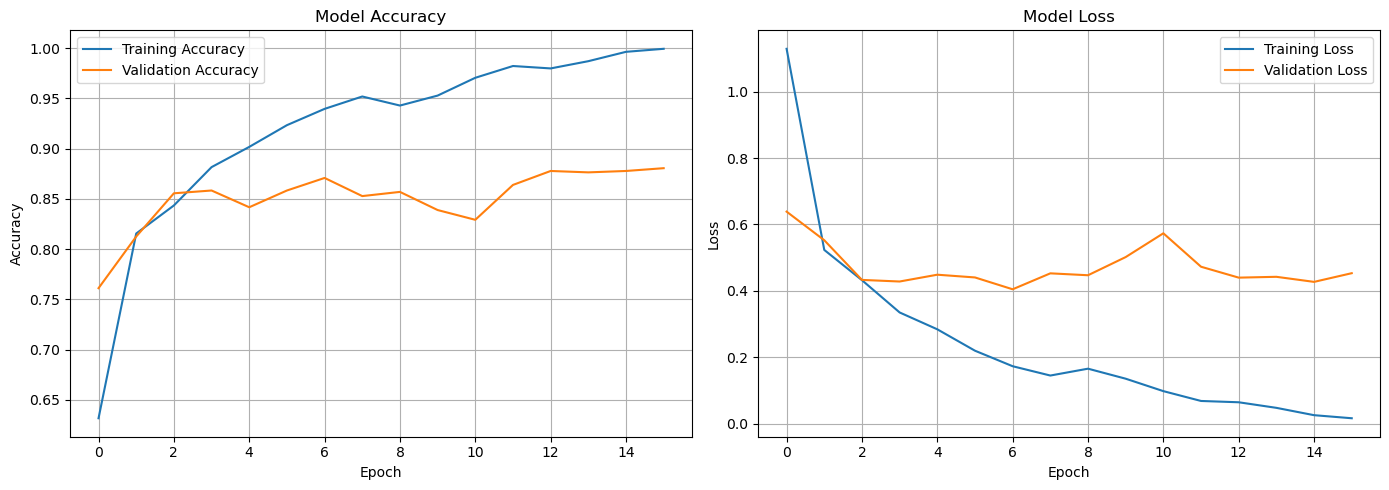


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.9994
Final Validation Accuracy: 0.8806
Final Training Loss: 0.0162
Final Validation Loss: 0.4532
--------------------------------------------------


In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

## Phase 2: Fine-Tuning by unfreezing layers

### Fine-Tuning Strategy

**Selective Layer Unfreezing:**
- **Base model trainable**: Set to `True` to allow weight updates
- **Layers unfrozen**: Last 10 layers of InceptionV3
- **Layers frozen**: All earlier layers remain frozen to preserve low-level features

```
Layer 0   ←─┐
Layer 1     │
Layer 2     │
...         ├─ These stay FROZEN
Layer 299   │
Layer 300   │
Layer 301 ──┘
Layer 302 ←─┐
Layer 303   │
Layer 304   │
...         ├─ These become TRAINABLE (last 10 layers)
Layer 308   │
Layer 309   │
Layer 310 ──┘
```

**Why unfreeze only the last 10 layers?**
- Early layers learn generic features so keep these frozen
- Later layers learn task-specific features because of that fine-tune these for our dataset
- Reduces risk of overfitting and catastrophic forgetting

**Why use a much smaller learning rate (1e-5) for fine-tuning?**
- Pre-trained weights are already optimized on millions of ImageNet images
- Large learning rates (0.001) cause catastrophic forgetting - destroying valuable features
- Small learning rates (1e-5) make gentle adjustments without breaking pre-trained knowledge
- Allows the model to adapt to your dataset while preserving general visual understanding

In [57]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable
base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to compile model every time there is a change)
model_InceptionV3.compile(loss = "sparse_categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5), 
                 metrics = ["accuracy"] )

## Verify Trainable Layers
Check which layers in the InceptionV3 base model are frozen vs trainable

In [58]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_InceptionV3.layers[1].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer_13 False
1 conv2d_208 False
2 batch_normalization_188 False
3 activation_188 False
4 conv2d_209 False
5 batch_normalization_189 False
6 activation_189 False
7 conv2d_210 False
8 batch_normalization_190 False
9 activation_190 False
10 max_pooling2d_20 False
11 conv2d_211 False
12 batch_normalization_191 False
13 activation_191 False
14 conv2d_212 False
15 batch_normalization_192 False
16 activation_192 False
17 max_pooling2d_21 False
18 conv2d_216 False
19 batch_normalization_196 False
20 activation_196 False
21 conv2d_214 False
22 conv2d_217 False
23 batch_normalization_194 False
24 batch_normalization_197 False
25 activation_194 False
26 activation_197 False
27 average_pooling2d_18 False
28 conv2d_213 False
29 conv2d_215 False
30 conv2d_218 False
31 conv2d_219 False
32 batch_normalization_193 False
33 batch_normalization_195 False
34 batch_normalization_198 False
35 batch_normalization_199 False
36 activation_193 False
37 activation_195 False
38 activation_198 False
39 a

In [59]:
# Now we have unfrozen some of the layers on the top 
print(len(model_InceptionV3.trainable_variables))

5


## Fine-Tuning Training
Continue training from epoch 16 for 4 additional epochs with unfrozen layers.

In [60]:
initial_epochs = 16
fine_tune_epochs = initial_epochs + 4

# Refit the model
history_2 = model_InceptionV3.fit(train_dataset,
                       epochs = fine_tune_epochs,
                       validation_data = cv_dataset,
                       initial_epoch = initial_epochs) 

Epoch 17/20


2025-11-26 12:53:05.443691: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_8529_0', 208 bytes spill stores, 952 bytes spill loads



104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 350ms/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.8903 - val_loss: 0.4244
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 33s 301ms/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.8875 - val_loss: 0.4281
Epoch 19/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 34s 308ms/step - accuracy: 1.0000 - loss: 0.0084 - val_accuracy: 0.8875 - val_loss: 0.4266
Epoch 20/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 35s 314ms/step - accuracy: 1.0000 - loss: 0.0080 - val_accuracy: 0.8875 - val_loss: 0.4258


In [61]:
model_InceptionV3.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.8963 - loss: 0.3685


[0.36850470304489136, 0.8963068127632141]

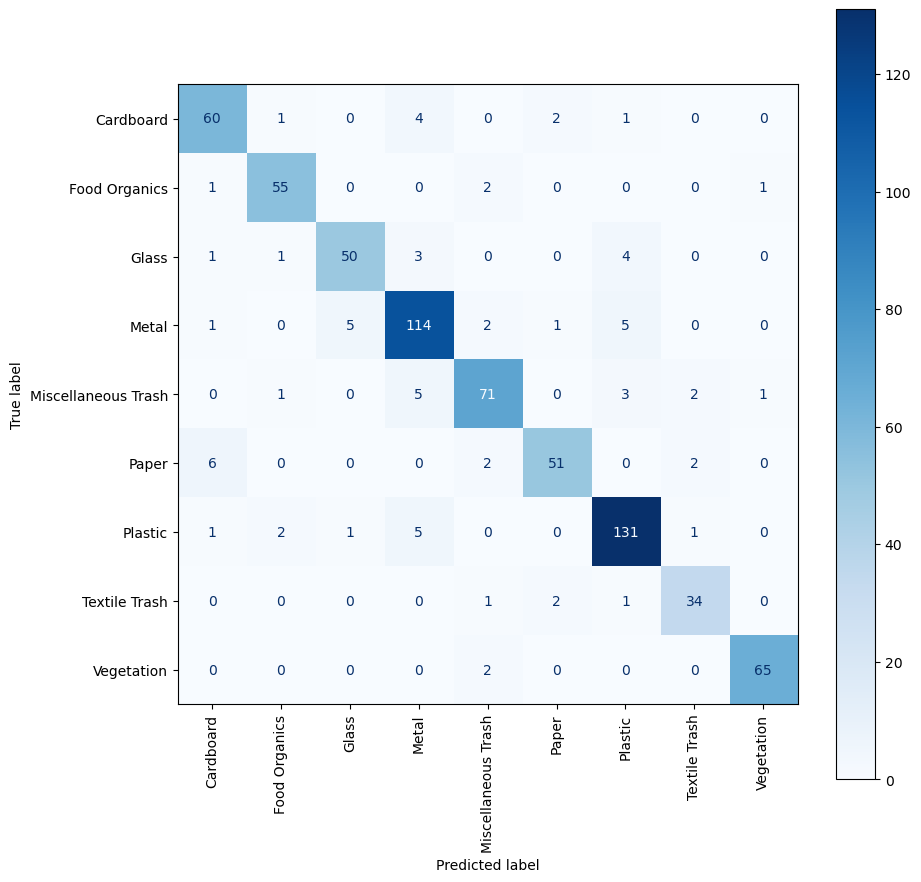

In [62]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model_InceptionV3.predict(imgs, verbose=0)
    
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [64]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model_InceptionV3.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.8965446242585888
Recall = 0.8963068181818182
F1 Score = 0.8961145508328143


# DesNet121

In [65]:
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam

## Model Architecture: Transfer Learning with DenseNet121

**Base Model Configuration:**
- **Architecture**: DenseNet121 (pre-trained on ImageNet)
- **Input shape**: (524, 524, 3)
- **Top layer**: Excluded - custom classifier added
- **Base model**: Frozen (all layers trainable=False)

**Custom Classification Head:**
- GlobalAveragePooling2D → Dense(2048, ReLU) → Dense(9, softmax)

**Training Strategy:**
- Train for 16 epochs with frozen base (lr=0.001)
- Fine-tune last layers for 4 epochs (lr=1e-5)

In [66]:
base_model = DenseNet121(input_shape = (524, 524, 3),
                         include_top = False,
                         weights = 'imagenet'
                         )

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(layers.GlobalAveragePooling2D())

# Add fully connected layers with dropout for regularization
model.add(layers.Dense(units = 2048, activation = "relu"))

model.add(layers.Dense(9, activation = "softmax"))

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 16, 16, 1024)   │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 9)              │        18,441 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,155,145 (34.92 MB)

 Trainable params: 2,117,641 (8.08 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [67]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']            
)    

In [68]:
# Train the model 
history = model.fit(
    train_dataset,                                  
    epochs=16,                                        
    validation_data=cv_dataset,               
)

Epoch 1/16


2025-11-26 13:06:31.089593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17321', 36 bytes spill stores, 44 bytes spill loads

2025-11-26 13:06:31.281468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11985', 160 bytes spill stores, 448 bytes spill loads

2025-11-26 13:06:31.551676: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17321', 32 bytes spill stores, 32 bytes spill loads

2025-11-26 13:06:31.648179: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_11985', 3908 bytes spill stores, 3896 bytes spill loads

2025-11-26 13:06:31.715503: I 

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5403 - loss: 1.4068

2025-11-26 13:07:57.029118: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292_0', 200 bytes spill stores, 416 bytes spill loads

2025-11-26 13:07:57.134637: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292', 4 bytes spill stores, 4 bytes spill loads

2025-11-26 13:07:57.228502: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292', 60 bytes spill stores, 128 bytes spill loads

2025-11-26 13:07:57.460669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3292', 3908 bytes spill stores, 3896 bytes spill loads

2025-11-26 13:07:57.522546: I ext

104/104 ━━━━━━━━━━━━━━━━━━━━ 118s 699ms/step - accuracy: 0.6761 - loss: 0.9599 - val_accuracy: 0.8139 - val_loss: 0.5617
Epoch 2/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 395ms/step - accuracy: 0.8302 - loss: 0.5010 - val_accuracy: 0.8278 - val_loss: 0.4695
Epoch 3/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 390ms/step - accuracy: 0.8681 - loss: 0.3837 - val_accuracy: 0.8431 - val_loss: 0.4246
Epoch 4/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 390ms/step - accuracy: 0.8819 - loss: 0.3351 - val_accuracy: 0.8667 - val_loss: 0.3537
Epoch 5/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - accuracy: 0.9216 - loss: 0.2429 - val_accuracy: 0.8639 - val_loss: 0.3891
Epoch 6/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 399ms/step - accuracy: 0.9240 - loss: 0.2165 - val_accuracy: 0.8472 - val_loss: 0.4269
Epoch 7/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 385ms/step - accuracy: 0.9396 - loss: 0.1751 - val_accuracy: 0.8750 - val_loss: 0.3573
Epoch 8/16
104/104 ━━━━━━━━━━━━━━━━━━━━ 41s 373ms/step - accuracy: 0.9552 - loss: 0.1328 - va

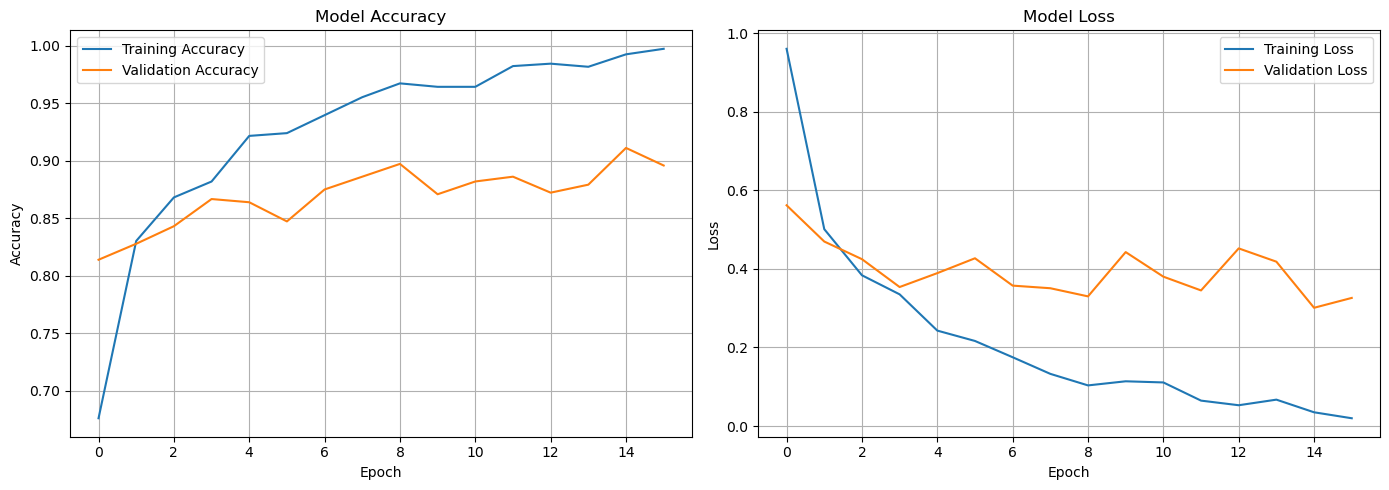


--------------------------------------------------
BASELINE MODEL PERFORMANCE
Final Training Accuracy: 0.9973
Final Validation Accuracy: 0.8958
Final Training Loss: 0.0198
Final Validation Loss: 0.3260
--------------------------------------------------


In [69]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Final Performance
print("\n" + "-"*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print("-"*50)

In [70]:
# To begin fine-tuning lets start by setting the last 10 layers as trainable
base_model.trainable = True

# Un-freeze last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile 
model.compile(loss = "sparse_categorical_crossentropy",
                optimizer =  tf.keras.optimizers.Adam(learning_rate = 1e-5), 
                 metrics = ["accuracy"] )

In [71]:
initial_epochs = 16
fine_tune_epochs = initial_epochs + 4

# Refit the model
history_2 = model.fit(train_dataset,
                       epochs = fine_tune_epochs,
                       validation_data = cv_dataset,
                       initial_epoch =  initial_epochs) 

Epoch 17/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 62s 479ms/step - accuracy: 1.0000 - loss: 0.0086 - val_accuracy: 0.9083 - val_loss: 0.3121
Epoch 18/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 384ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9069 - val_loss: 0.3118
Epoch 19/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 45s 403ms/step - accuracy: 1.0000 - loss: 0.0073 - val_accuracy: 0.9056 - val_loss: 0.3130
Epoch 20/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 43s 393ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.9069 - val_loss: 0.3136


In [72]:
model.evaluate(test_dataset)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step - accuracy: 0.9190 - loss: 0.3061


[0.30612459778785706, 0.9190340638160706]

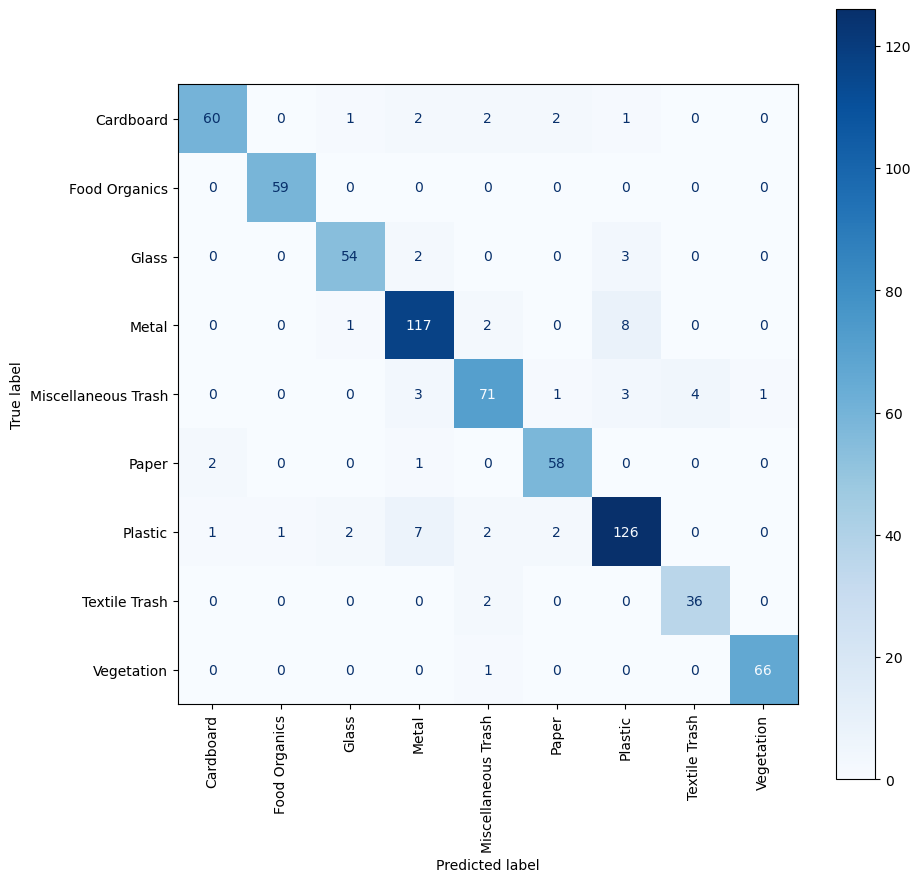

In [73]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

num_classes = len(class_names) 

y_true = []
y_pred = []

# collect predictions for the entire test set
for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    
    y_true.append(labels.numpy())
    y_pred.append(np.argmax(preds, axis=1))

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# build confusion matrix with all 9 classes
conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(num_classes))

# plot
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax, values_format="d")
plt.setp(ax.get_xticklabels(), rotation=90, ha="center", fontsize=10)
plt.show()


In [74]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

for imgs, labels in test_dataset:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


Precision = 0.9192974169383603
Recall = 0.9190340909090909
F1 Score = 0.918897733168042
